# XCDAT Demo: testing general functions on regridded E3SM data
In this document, E3SM model output is loaded by using [xcdat](https://xcdat.readthedocs.io/en/latest/). 

Demo data used in this document is the time-series of regridded surface temperature (ts) simulated by E3SM, and the model's land fraction. Those data can be found from [E3SM data server](https://web.lcrc.anl.gov/public/e3sm/e3sm_diags_test_data/time-series/E3SM_v1/)

Author: Jiwoo Lee, Jill Zhang (2021. 10)

In [78]:
import os

In [79]:
demo_data_dir = '/Users/zhang40/Documents/ACME_simulations/E3SM_v1'
demo_filename = 'TS_185001_201312.nc'
demo_file = os.path.join(demo_data_dir, demo_filename)

## 1. Open dataset using xcdat

### 1.1 Load dataset into memory

In [80]:
import xcdat
import xarray as xr

In [81]:
ds = xcdat.open_dataset(demo_file, data_var = 'TS')

In [82]:
ts = ds.TS

### 1.2 Data quick check

#### Check dimensions

In [83]:
ts.shape

(1968, 129, 256)

#### Field quick view -- plot data on the first time step

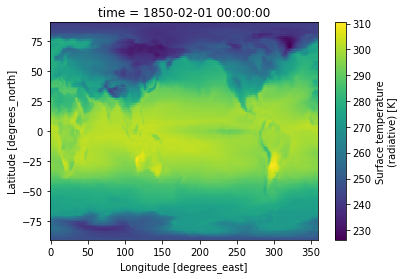

In [84]:
ts.isel(time=0).plot()

# Or, below commends do the same:

# ts[0].plot()
# ts.isel(time=slice(0, 1)).plot()
# ts.sel(time=ds.ts.time[0]).plot()

#### Check date of first time step: Note that monthly E3SM data recode time at the end of each time interval. The first time step is decoded as Feb 1st. 

In [85]:
ts.time[0].values

array(cftime.DatetimeNoLeap(1850, 2, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)

#### Check date of last time step 

In [86]:
ts.time[-1].values

array(cftime.DatetimeNoLeap(2014, 1, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)

### 1.3 Subset

#### Original dimensions

In [87]:
ts.shape

(1968, 129, 256)

#### Temporal subset

In [88]:
ts1 = ts.sel(time=slice('1851-01-01', '1851-12-31'))
ts1.shape

(12, 129, 256)

#### Spatial subset

In [89]:
ts2 = ts.sel(lat=slice(20, 50), lon=slice(220, 320))
ts2.shape

(1968, 21, 71)

#### Spatio-tempoal subset

In [90]:
ts3 = ts.sel(time=slice('1851-01-01 00:00:00', '1851-12-31 23:59:59'), lat=slice(20, 50), lon=slice(220, 320))
ts3.shape

(12, 21, 71)

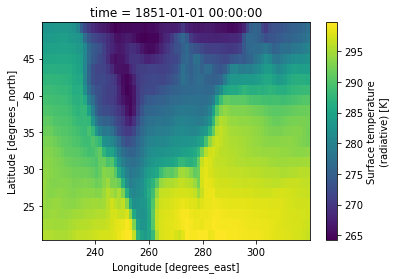

In [91]:
ts3[0].plot()

You can also visualize data on a map using [cartropy](https://scitools.org.uk/cartopy/docs/latest/) as below. Useage example also can be found [here](http://xarray.pydata.org/en/stable/user-guide/plotting.html).

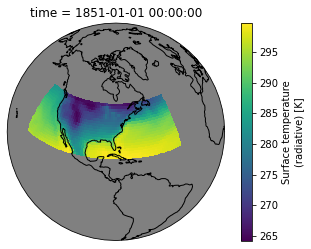

In [114]:
import cartopy.crs as ccrs

p = ts3.isel(time=0).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(-80, 35), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)

p.axes.set_global()

p.axes.coastlines()

PMP uses [predefined domains](https://github.com/PCMDI/pcmdi_metrics/blob/master/share/default_regions.py), as well as E3SM_diags [predefined_domains](https://github.com/E3SM-Project/e3sm_diags/blob/master/e3sm_diags/derivations/default_regions.py). Below capability was made to mimic that capability.

In [93]:
def region_subset(d, regions_specs, region=None):
    
    if ((region == None) or 
        (region != None) and (region not in list(regions_specs.keys()))):
        print('Error: region not defined')
    else:    
        if 'domain' in list(regions_specs[region].keys()):
            if 'latitude' in list(regions_specs[region]['domain'].keys()):
                lat0 = regions_specs[region]['domain']['latitude'][0]
                lat1 = regions_specs[region]['domain']['latitude'][1]
                if 'latitude' in (d.coords.dims):
                    d = d.sel(latitude=slice(lat0, lat1))
                elif 'lat' in (d.coords.dims):
                    d = d.sel(lat=slice(lat0, lat1))

            if 'longitude' in list(regions_specs[region]['domain'].keys()):
                lon0 = regions_specs[region]['domain']['longitude'][0]
                lon1 = regions_specs[region]['domain']['longitude'][1]
                if 'longitude' in (d.coords.dims):
                    d = d.sel(longitude=slice(lon0, lon1))
                elif 'lon' in (d.coords.dims):
                    d = d.sel(lon=slice(lon0, lon1))

    return d

In [94]:
regions_specs = {
    'NHEX': {'domain': {'latitude': (30., 90)}},
    'SHEX': {'domain': {'latitude': (-90., 30)}},
    'TROPICS': {'domain': {'latitude': (-30., 30)}},
    'global': {},
    }

In [95]:
ts4 = region_subset(ts.sel(time=slice('1851-01-01 00:00:00', '1851-12-31 23:59:59')), regions_specs, 'NHEX')
ts4.shape

(12, 43, 256)

In [96]:
ts4 = region_subset(ts.sel(time=slice('1851-01-01 00:00:00', '1851-12-31 23:59:59')), regions_specs, 'TROPICS')
ts4.shape

(12, 43, 256)

Select Nearest grid box near an ARM site.

## 2. Annual Cycle

In [97]:
ts4 = region_subset(ts.sel(time=slice('1851-01-01 00:00:00', '1851-12-31 23:59:59')), regions_specs, 'global')
ts4.shape

(12, 129, 256)

In [98]:
ts_ann = ts.groupby('time.month').mean('time')

In [99]:
ts_ann.shape

(12, 129, 256)

## 3. Seasonal Mean

In [100]:
ts_seasons = ts.groupby('time.season').mean('time')

In [101]:
ts_seasons.shape

(4, 129, 256)

## 4. Land-sea mask

- Open land fraction of the given model grid and apply land or sea mask to the field of interest, using [`xarray.DataArray.where`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.where.html) capbility.
- Relvant example usage also can be found [here](https://geohackweek.github.io/nDarrays/09-masking/).

In [102]:
demo_lsmsk_filename = 'LANDFRAC_185001_201312.nc'
demo_lsmsk_file = os.path.join(demo_data_dir, demo_lsmsk_filename)

In [103]:
ds_lsmsk = xcdat.open_dataset(demo_lsmsk_file, data_var = 'LANDFRAC')

In [104]:
sftlf = ds_lsmsk.LANDFRAC

### 4.1 Land

In [105]:
ts_land = ts.where(sftlf!=0.)

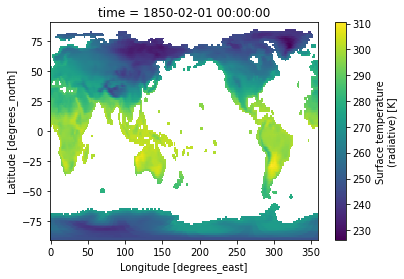

In [106]:
ts_land.isel(time=0).plot()

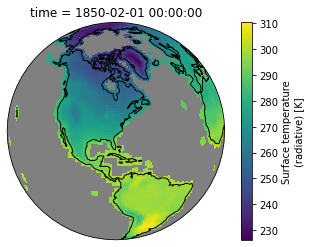

In [112]:
p = ts_land.isel(time=0).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(-80, 35), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)

p.axes.set_global()

p.axes.coastlines()

### 4.2 Ocean

In [108]:
ts_sea = ts.where(sftlf==0.)

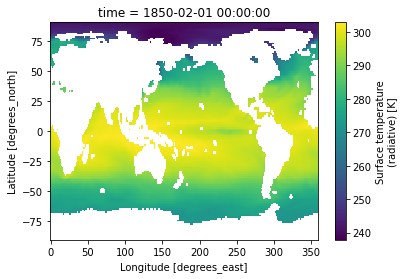

In [109]:
ts_sea.isel(time=0).plot()

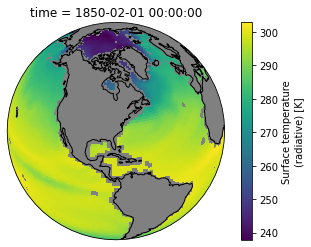

In [113]:
p = ts_sea.isel(time=0).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(-80, 35), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)

p.axes.set_global()

p.axes.coastlines()

In [111]:
points_specs = {
    # ARM sites coordinates, select nearest grid poit to ARM site coordinates
    # Each point is supplied with [latitude, longitude ,select method, description of the point]
    "sgp": [36.4, -97.5, "cob", "97.5W 36.4N Oklahoma ARM"],
    "nsa": [71.3, -156.6, "cob", "156.6W 71.3N Barrow ARM"],
    "twpc1": [-2.1, 147.4, "cob", "147.4E 2.1S Manus ARM"],
    "twpc2": [-0.5, 166.9, "cob", "166.9E 0.5S Nauru ARM"],
    "twpc3": [-12.4, 130.9, "cob", "130.9E 12.4S Darwin ARM"],
}



sgp_lat = points_specs["sgp"][0]
sgp_lon =  (360 + points_specs["sgp"][1]) # note, convert longitude is required. 
ts_sgp = ts.sel(lon=sgp_lon, lat=sgp_lat, method="nearest")
